Attempting to fetch TLEs for 23560 from 2023-08-01 to 2024-02-20...
Space-Track login successful.
Successfully fetched TLE data (562 sets found).
Parsing TLEs...
Successfully parsed 562 TLE sets.
Calculating derived parameters...
Derived parameter calculation complete.
Generating plots...


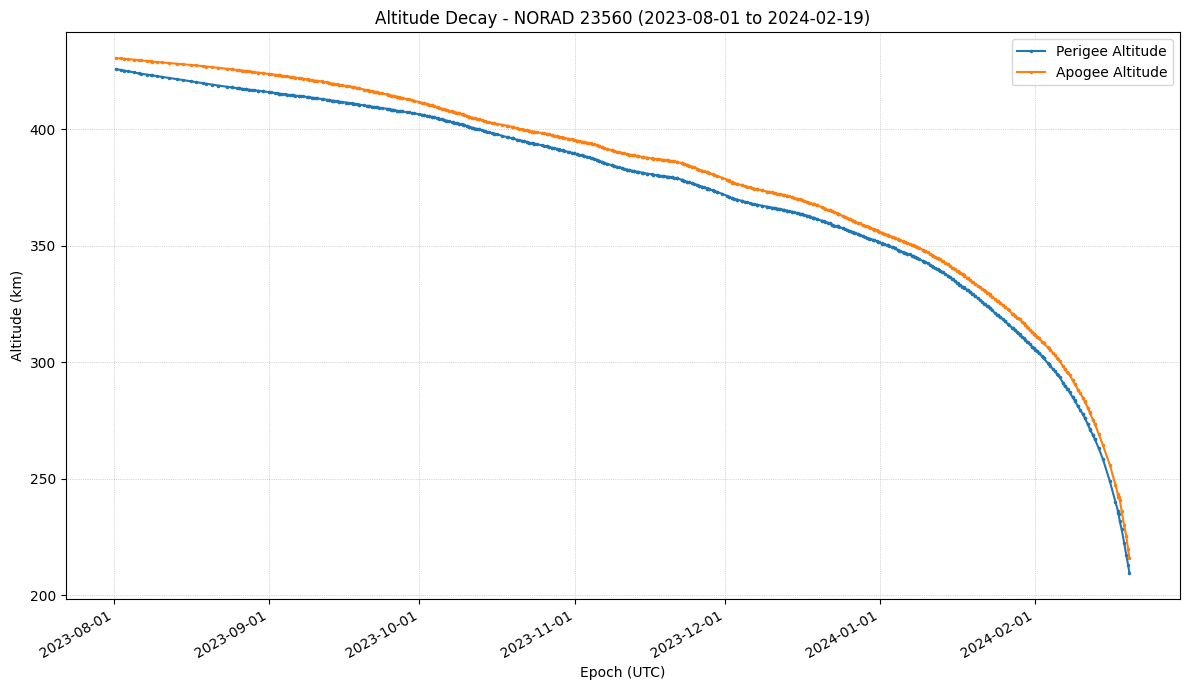

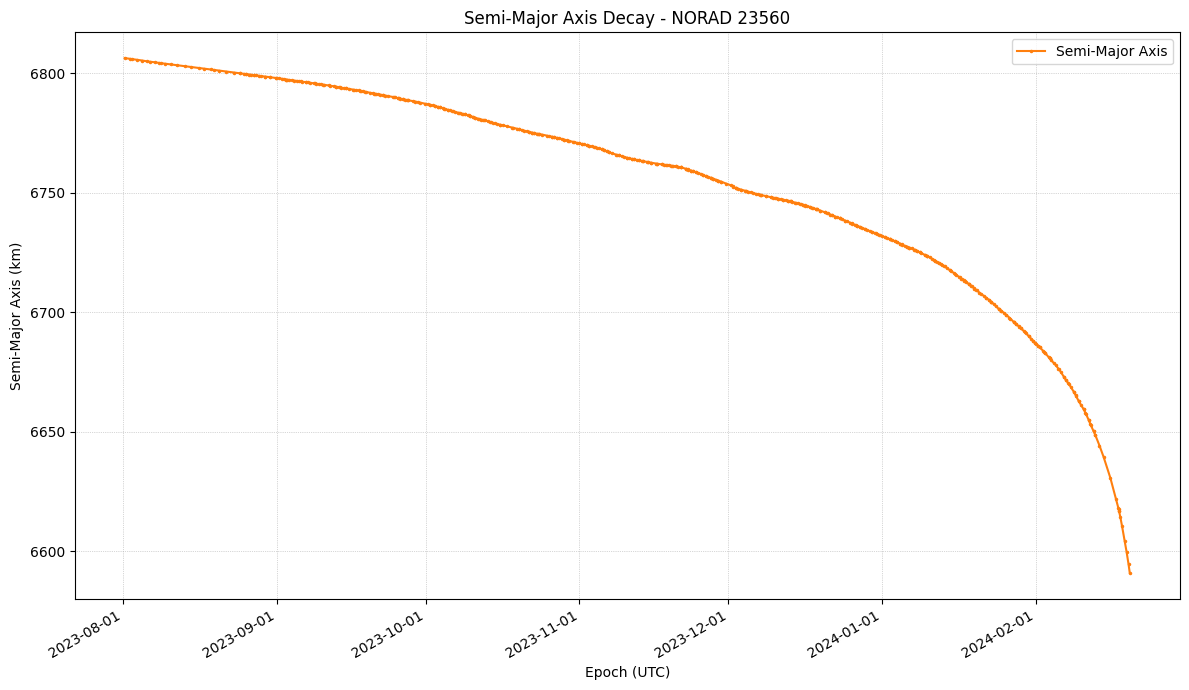

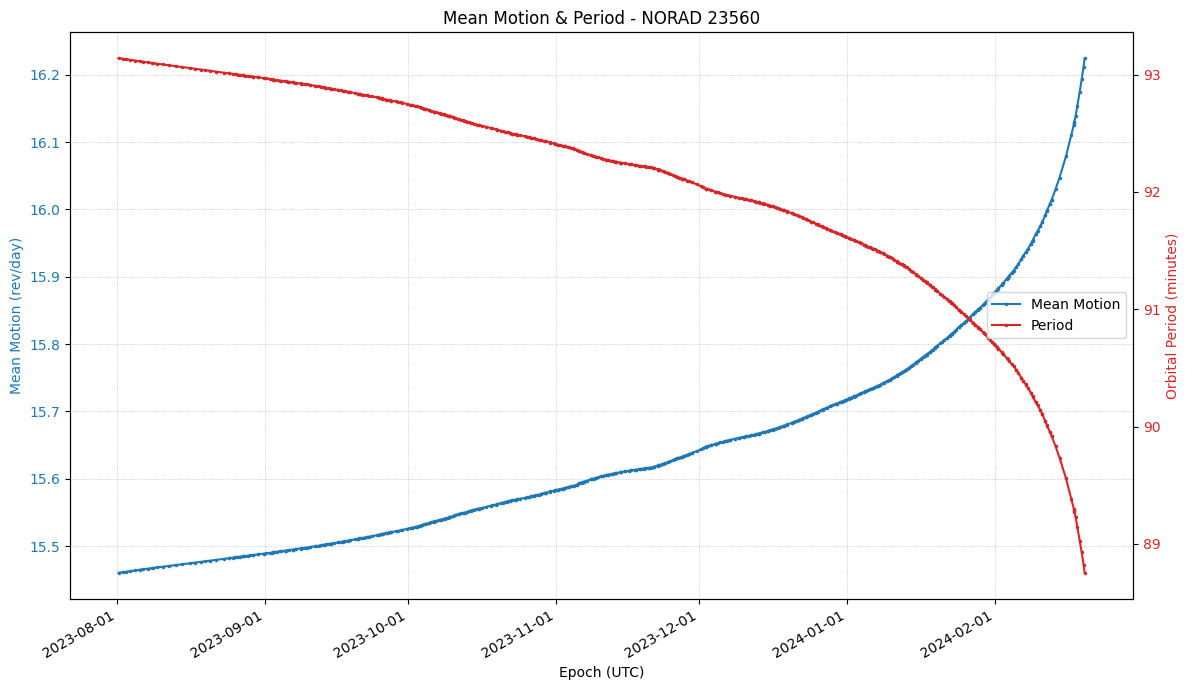

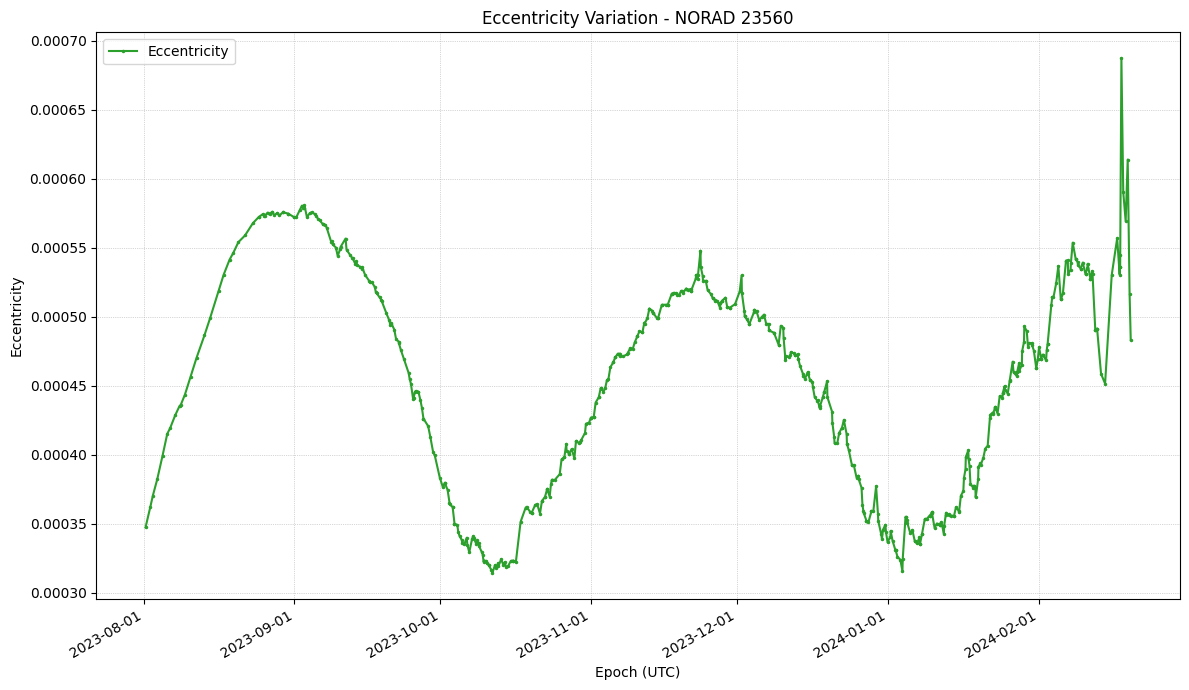

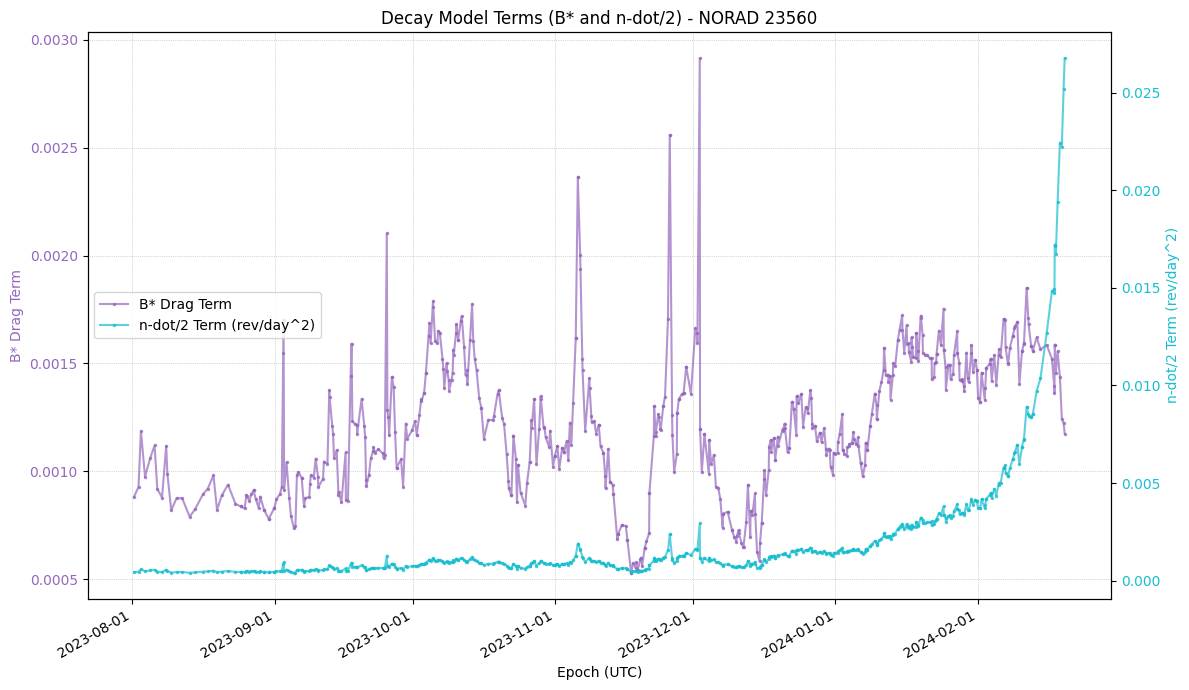

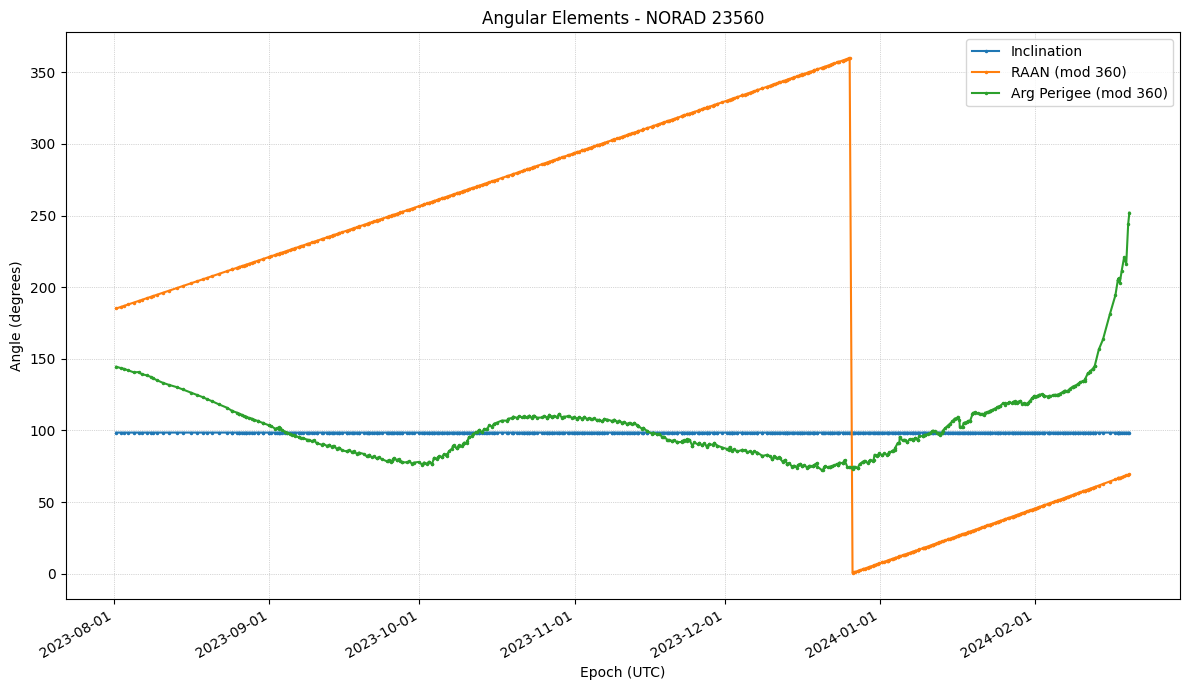

Plot generation complete.

--- Statistical Analysis (Perigee Decay Rate) ---

Perigee Altitude Decay Rate Statistics:
count    475.000000
mean      -1.168373
std        1.864153
min      -16.248660
25%       -1.137327
50%       -0.624853
75%       -0.379869
max        2.543833
Name: Perigee_decay_rate_km_day, dtype: float64

Average Decay Rate (first half): -0.445 km/day
Average Decay Rate (second half): -1.920 km/day


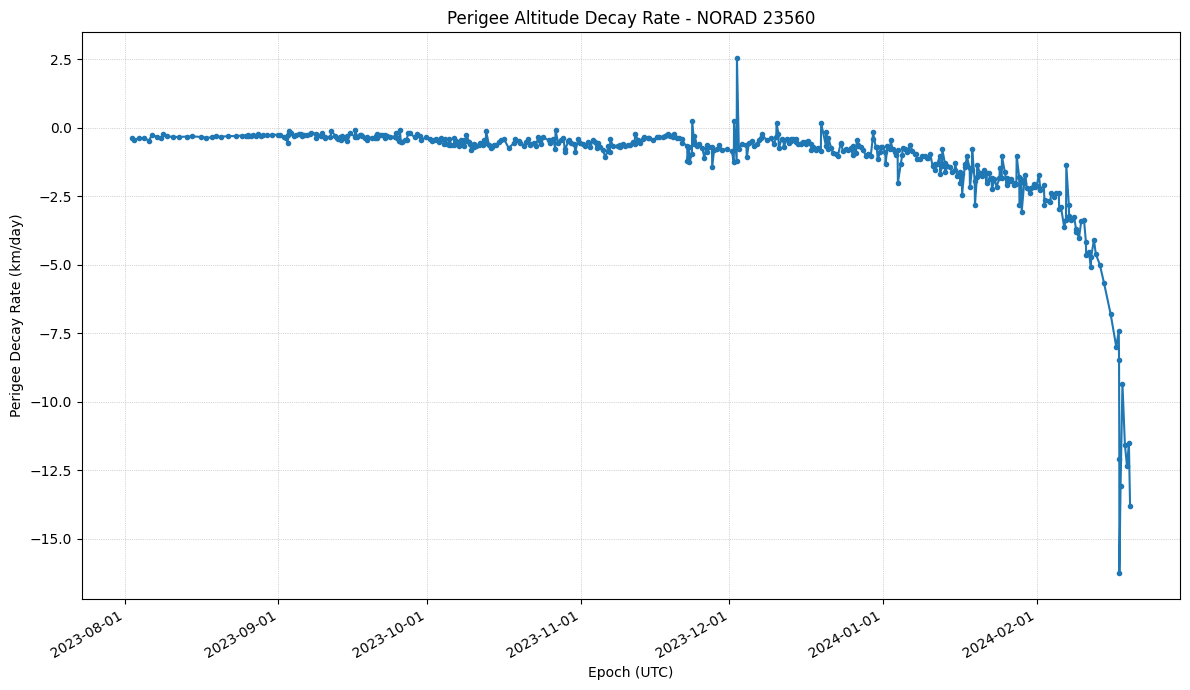


--- Correlation Matrix Analysis ---
Calculating correlation matrix using 562 data points.


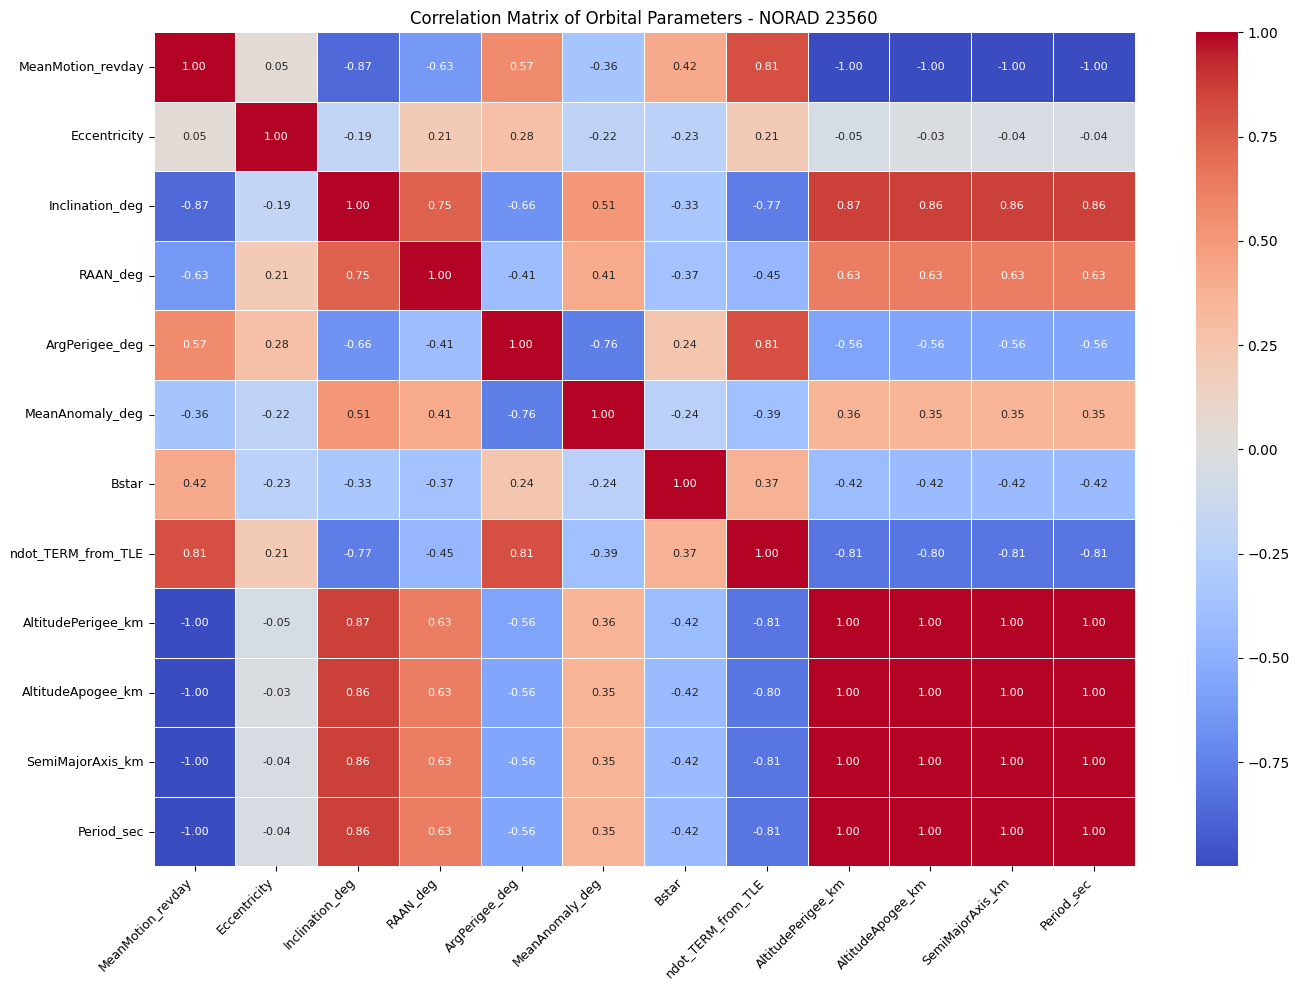

Correlation matrix generated.


In [ ]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sgp4.api import Satrec, jday
from datetime import datetime, timedelta
import io

# --- 1. Configuration ---
SPACETRACK_USER = 'rvit21bcs032.rvitm@rvei.edu.in'
SPACETRACK_PASS = 'xyz'
SPACETRACK_URI = "https://www.space-track.org"

# Target Object and Date Range
NORAD_ID = 23560 # ERS-2
START_DATE = '2023-08-01'
END_DATE = '2024-02-20' # Day before re-entry

# Constants
GM_EARTH = 3.986004418e14 # m^3/s^2 (WGS84)
R_EARTH = 6378137.0      # meters (WGS84 Earth radius)

# --- 2. Space-Track Data Acquisition ---
def get_space_track_tles(norad_id, start_date, end_date, user, password):
    """Logs into Space-Track and fetches TLE data."""
    print(f"Attempting to fetch TLEs for {norad_id} from {start_date} to {end_date}...")
    login_data = {'identity': user, 'password': password}
    query_url = (f"{SPACETRACK_URI}/basicspacedata/query/class/tle/NORAD_CAT_ID/{norad_id}/"
                 f"EPOCH/{start_date}--{end_date}/orderby/EPOCH%20asc/format/tle")

    try:
        with requests.Session() as session:
            # Login
            login_response = session.post(SPACETRACK_URI + '/ajaxauth/login', data=login_data)
            login_response.raise_for_status() # Raise exception for bad status codes (4xx or 5xx)
            print("Space-Track login successful.")

            # Fetch TLEs
            tle_response = session.get(query_url)
            tle_response.raise_for_status()
            print(f"Successfully fetched TLE data ({len(tle_response.text.splitlines()) // 2} sets found).")
            return tle_response.text

    except requests.exceptions.RequestException as e:
        print(f"Error during Space-Track request: {e}")
        if 'login_response' in locals() and login_response and login_response.status_code == 401:
             print("--> Check your Space-Track credentials.")
        elif 'tle_response' in locals() and tle_response and (tle_response.status_code == 404 or tle_response.status_code >= 500):
             print("--> Possible issue with Space-Track API or query parameters.")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

# --- 3. TLE Parsing & Parameter Extraction (FIXED) ---
def parse_tles(tle_data):
    """Parses raw TLE text data into a list of dictionaries."""
    print("Parsing TLEs...")
    if not tle_data:
        print("No TLE data to parse.")
        return pd.DataFrame()

    lines = tle_data.strip().splitlines()
    tles = []

    line_idx = 0
    while line_idx < len(lines) - 1:
        line1 = lines[line_idx].strip()
        line2 = lines[line_idx+1].strip()

        # Skip empty lines
        if not line1 or not line2:
            line_idx += 1
            continue

        # Basic validation that we have a TLE pair
        if line1.startswith('1 ') and line2.startswith('2 '):
            try:
                sat = Satrec.twoline2rv(line1, line2)

                # Extract epoch components
                year = sat.epochyr
                if year < 57:  # Y2K fix
                    year += 2000
                else:
                    year += 1900

                # Get fractional day
                day = sat.epochdays
                day_int = int(day)
                frac_day = day - day_int

                # Create a date for Jan 1 of the epoch year
                base_date = datetime(year, 1, 1)
                # Add days (subtract 1 because day_int is 1-based)
                dt_epoch = base_date + timedelta(days=day_int-1, seconds=frac_day*86400.0)

                # Extract n-dot/2 directly from TLE Line 1 (columns 34-43)
                ndot_raw = line1[33:43].strip()
                # Add implicit decimal point if missing and format allows
                if '.' not in ndot_raw and len(ndot_raw) > 1 :
                    ndot_raw = ndot_raw[0] + '.' + ndot_raw[1:] # Assumes format like -12345-4 -> -.12345e-4
                # Use standard scientific notation parsing
                try:
                    # Replace space before exponent sign if present (sometimes seen in TLEs)
                    ndot_raw = ndot_raw.replace(' -','e-').replace(' +','e+')
                    # Handle the case where exponent sign is missing (should technically be '+')
                    if 'e' not in ndot_raw and ('-' in ndot_raw[1:] or '+' in ndot_raw[1:]):
                         if '-' in ndot_raw[1:]:
                             parts = ndot_raw.split('-')
                             ndot_raw = parts[0] + 'e-' + parts[1]
                         elif '+' in ndot_raw[1:]:
                             parts = ndot_raw.split('+')
                             ndot_raw = parts[0] + 'e+' + parts[1]

                    # Now parse the scientific notation
                    ndot_term = float(ndot_raw)

                except ValueError:
                    print(f"Warning: Could not parse ndot_term '{line1[33:43]}' for TLE epoch {dt_epoch}. Setting to 0.")
                    ndot_term = 0.0

                # *** FIX: Store mean motion in rad/min and calculate rev/day correctly ***
                mean_motion_rad_min = sat.no_kozai
                mean_motion_rev_day = mean_motion_rad_min * (60.0 * 24.0) / (2.0 * np.pi) # Correct conversion

                tles.append({
                    'Epoch': dt_epoch,
                    'MeanMotion_rad_min': mean_motion_rad_min,  # Store rad/min
                    'MeanMotion_revday': mean_motion_rev_day,    # Store correctly calculated rev/day
                    'Eccentricity': sat.ecco,
                    'Inclination_deg': np.degrees(sat.inclo),
                    'RAAN_deg': np.degrees(sat.nodeo),
                    'ArgPerigee_deg': np.degrees(sat.argpo),
                    'MeanAnomaly_deg': np.degrees(sat.mo),
                    'Bstar': sat.bstar,
                    'ndot_TERM_from_TLE': ndot_term, # This is ndot/2 in rev/day^2 from TLE
                })
                line_idx += 2  # Move to the next pair

            except Exception as e:
                print(f"Error parsing TLE pair: {e}")
                print(f"Line 1: {line1}")
                print(f"Line 2: {line2}")
                line_idx += 1  # Skip this problematic line
        else:
             # print(f"Skipping non-TLE line pair starting with: '{line1[:5]}', '{line2[:5]}'") # Optional: for debugging TLE format issues
            line_idx += 1 # Skip this line

    if not tles:
        print("No TLEs could be successfully parsed. Check the format of your TLE data.")
        return pd.DataFrame()

    print(f"Successfully parsed {len(tles)} TLE sets.")
    return pd.DataFrame(tles)

# --- 4. Derived Parameter Calculation ---
def calculate_derived_params(df):
    """Calculates altitudes, period, semi-major axis."""
    print("Calculating derived parameters...")
    if df.empty or 'MeanMotion_rad_min' not in df.columns: # Check if required column exists
        print("DataFrame is empty or missing 'MeanMotion_rad_min'. Cannot calculate derived parameters.")
        return df

    # *** FIX: Convert mean motion from rad/min to rad/sec ***
    n_rad_per_sec = df['MeanMotion_rad_min'] / 60.0

    # Calculate semi-major axis (a) in meters
    valid_n = n_rad_per_sec > 0
    df['SemiMajorAxis_m'] = np.nan
    # Use the correct n_rad_per_sec here
    df.loc[valid_n, 'SemiMajorAxis_m'] = (GM_EARTH / n_rad_per_sec[valid_n]**2)**(1.0/3.0)
    df['SemiMajorAxis_km'] = df['SemiMajorAxis_m'] / 1000.0 # Add SMA in km

    # Calculate orbital period in seconds
    df['Period_sec'] = np.nan
    # Use the correct n_rad_per_sec here
    df.loc[valid_n, 'Period_sec'] = 2.0 * np.pi / n_rad_per_sec[valid_n]

    # Calculate perigee and apogee radius (meters) - Check for NaN SMA first
    valid_sma = df['SemiMajorAxis_m'].notna()
    df['AltitudePerigee_km'] = np.nan
    df['AltitudeApogee_km'] = np.nan

    rp = df.loc[valid_sma, 'SemiMajorAxis_m'] * (1.0 - df.loc[valid_sma, 'Eccentricity'])
    ra = df.loc[valid_sma, 'SemiMajorAxis_m'] * (1.0 + df.loc[valid_sma, 'Eccentricity'])

    # Calculate altitudes (km), subtracting Earth radius
    df.loc[valid_sma, 'AltitudePerigee_km'] = (rp - R_EARTH) / 1000.0
    df.loc[valid_sma, 'AltitudeApogee_km'] = (ra - R_EARTH) / 1000.0

    # Handle cases where calculation might have failed (e.g., n=0)
    original_rows = len(df)
    df.dropna(subset=['SemiMajorAxis_m', 'AltitudePerigee_km', 'AltitudeApogee_km'], inplace=True)
    dropped_rows = original_rows - len(df)
    if dropped_rows > 0:
        print(f"Dropped {dropped_rows} rows due to invalid derived parameter calculations.")


    print("Derived parameter calculation complete.")
    return df

# --- 5. Plotting ---
def plot_data(df, norad_id):
    """Generates plots of key orbital parameters over time."""
    print("Generating plots...")
    if df.empty:
        print("DataFrame is empty, cannot plot.")
        return

    df = df.sort_index() # Ensure data is sorted by time

    # --- Plot Altitudes (Perigee/Apogee) ---
    fig1, ax1 = plt.subplots(figsize=(12, 7))
    ax1.plot(df.index, df['AltitudePerigee_km'], marker='.', markersize=3, linestyle='-', label='Perigee Altitude')
    ax1.plot(df.index, df['AltitudeApogee_km'], marker='.', markersize=3, linestyle='-', label='Apogee Altitude')
    ax1.set_xlabel('Epoch (UTC)')
    ax1.set_ylabel('Altitude (km)')
    ax1.set_title(f'Altitude Decay - NORAD {norad_id} ({df.index.min().date()} to {df.index.max().date()})')
    ax1.legend()
    ax1.grid(True, which='both', linestyle=':', linewidth=0.5)
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    fig1.autofmt_xdate()
    plt.tight_layout()
    plt.show()

    # --- Plot Semi-Major Axis ---
    fig_sma, ax_sma = plt.subplots(figsize=(12, 7))
    ax_sma.plot(df.index, df['SemiMajorAxis_km'], marker='.', markersize=3, linestyle='-', label='Semi-Major Axis', color='tab:orange')
    ax_sma.set_xlabel('Epoch (UTC)')
    ax_sma.set_ylabel('Semi-Major Axis (km)')
    ax_sma.set_title(f'Semi-Major Axis Decay - NORAD {norad_id}')
    ax_sma.legend()
    ax_sma.grid(True, which='both', linestyle=':', linewidth=0.5)
    ax_sma.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    fig_sma.autofmt_xdate()
    plt.tight_layout()
    plt.show()

    # --- Plot Mean Motion and Period ---
    fig2, ax2a = plt.subplots(figsize=(12, 7))
    color1 = 'tab:blue'
    ax2a.plot(df.index, df['MeanMotion_revday'], marker='.', markersize=3, linestyle='-', color=color1, label='Mean Motion')
    ax2a.set_xlabel('Epoch (UTC)')
    ax2a.set_ylabel('Mean Motion (rev/day)', color=color1)
    ax2a.tick_params(axis='y', labelcolor=color1)
    ax2a.grid(True, which='both', linestyle=':', linewidth=0.5)
    ax2a.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax2b = ax2a.twinx()
    color2 = 'tab:red'
    ax2b.plot(df.index, df['Period_sec'] / 60.0, marker='.', markersize=3, linestyle='-', color=color2, label='Period')
    ax2b.set_ylabel('Orbital Period (minutes)', color=color2)
    ax2b.tick_params(axis='y', labelcolor=color2)
    ax2a.set_title(f'Mean Motion & Period - NORAD {norad_id}')
    lines, labels = ax2a.get_legend_handles_labels()
    lines2, labels2 = ax2b.get_legend_handles_labels()
    ax2b.legend(lines + lines2, labels + labels2, loc='center right')
    fig2.autofmt_xdate()
    plt.tight_layout()
    plt.show()

    # --- Plot Eccentricity ---
    fig_ecc, ax_ecc = plt.subplots(figsize=(12, 7))
    ax_ecc.plot(df.index, df['Eccentricity'], marker='.', markersize=3, linestyle='-', label='Eccentricity', color='tab:green')
    ax_ecc.set_xlabel('Epoch (UTC)')
    ax_ecc.set_ylabel('Eccentricity')
    ax_ecc.set_title(f'Eccentricity Variation - NORAD {norad_id}')
    ax_ecc.legend()
    ax_ecc.grid(True, which='both', linestyle=':', linewidth=0.5)
    ax_ecc.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    fig_ecc.autofmt_xdate()
    plt.tight_layout()
    plt.show()

    # --- Plot B* and n-dot/2 (Decay Terms) ---
    fig_decay, ax_decay1 = plt.subplots(figsize=(12, 7))
    color1 = 'tab:purple'
    ax_decay1.plot(df.index, df['Bstar'], marker='.', markersize=3, linestyle='-', alpha=0.7, color=color1, label='B* Drag Term')
    ax_decay1.set_xlabel('Epoch (UTC)')
    ax_decay1.set_ylabel('B* Drag Term', color=color1)
    ax_decay1.tick_params(axis='y', labelcolor=color1)
    ax_decay1.grid(True, which='both', linestyle=':', linewidth=0.5)
    ax_decay1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

    ax_decay2 = ax_decay1.twinx()
    color2 = 'tab:cyan'
    ax_decay2.plot(df.index, df['ndot_TERM_from_TLE'], marker='.', markersize=3, linestyle='-', alpha=0.7, color=color2, label='n-dot/2 Term (rev/day^2)')
    ax_decay2.set_ylabel('n-dot/2 Term (rev/day^2)', color=color2)
    ax_decay2.tick_params(axis='y', labelcolor=color2)

    ax_decay1.set_title(f'Decay Model Terms (B* and n-dot/2) - NORAD {norad_id}')
    lines, labels = ax_decay1.get_legend_handles_labels()
    lines2, labels2 = ax_decay2.get_legend_handles_labels()
    ax_decay2.legend(lines + lines2, labels + labels2, loc='center left') # Adjust legend position
    fig_decay.autofmt_xdate()
    plt.tight_layout()
    plt.show()

    # --- Plot Angular Elements ---
    fig4, ax4 = plt.subplots(figsize=(12, 7))
    ax4.plot(df.index, df['Inclination_deg'], marker='.', markersize=3, linestyle='-', label='Inclination')
    ax4.plot(df.index, df['RAAN_deg'] % 360, marker='.', markersize=3, linestyle='-', label='RAAN (mod 360)')
    ax4.plot(df.index, df['ArgPerigee_deg'] % 360, marker='.', markersize=3, linestyle='-', label='Arg Perigee (mod 360)')
    ax4.set_xlabel('Epoch (UTC)')
    ax4.set_ylabel('Angle (degrees)')
    ax4.set_title(f'Angular Elements - NORAD {norad_id}')
    ax4.legend(loc='best')
    ax4.grid(True, which='both', linestyle=':', linewidth=0.5)
    ax4.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    fig4.autofmt_xdate()
    plt.tight_layout()
    plt.show()

    print("Plot generation complete.")

# --- 6. Statistical Analysis ---
def analyze_decay_rate(df):
    """Calculates and prints basic decay rate statistics."""
    print("\n--- Statistical Analysis (Perigee Decay Rate) ---")
    if df.empty or len(df) < 2:
        print("Not enough data points for rate analysis.")
        return df # Return original df

    df_analysis = df.copy() # Work on a copy
    df_analysis = df_analysis.sort_index()
    df_analysis['Time_diff_days'] = df_analysis.index.to_series().diff().dt.total_seconds() / 86400.0
    df_analysis['AltitudePerigee_change_km'] = df_analysis['AltitudePerigee_km'].diff()

    df_analysis['Perigee_decay_rate_km_day'] = np.nan
    valid_diff = df_analysis['Time_diff_days'] > 1e-6
    df_analysis.loc[valid_diff, 'Perigee_decay_rate_km_day'] = df_analysis['AltitudePerigee_change_km'][valid_diff] / df_analysis['Time_diff_days'][valid_diff]

    print("\nPerigee Altitude Decay Rate Statistics:")
    decay_stats = df_analysis['Perigee_decay_rate_km_day'].dropna().describe()
    print(decay_stats)

    if len(df_analysis) > 4:
        mid_point_time = df_analysis.index[len(df_analysis) // 2]
        first_half_rate = df_analysis.loc[df_analysis.index < mid_point_time, 'Perigee_decay_rate_km_day'].mean()
        second_half_rate = df_analysis.loc[df_analysis.index >= mid_point_time, 'Perigee_decay_rate_km_day'].mean()
        print(f"\nAverage Decay Rate (first half): {first_half_rate:.3f} km/day")
        print(f"Average Decay Rate (second half): {second_half_rate:.3f} km/day")

    # --- Plot Decay Rate ---
    fig_rate, ax_rate = plt.subplots(figsize=(12, 7))
    valid_rates = df_analysis['Perigee_decay_rate_km_day'].dropna()
    ax_rate.plot(valid_rates.index, valid_rates, marker='o', markersize=3, linestyle='-')
    ax_rate.set_xlabel('Epoch (UTC)')
    ax_rate.set_ylabel('Perigee Decay Rate (km/day)')
    ax_rate.set_title(f'Perigee Altitude Decay Rate - NORAD {NORAD_ID}')
    ax_rate.grid(True, which='both', linestyle=':', linewidth=0.5)
    ax_rate.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    fig_rate.autofmt_xdate()
    plt.tight_layout()
    plt.show()

    return df_analysis # Return df with calculations

# --- 7. Correlation Matrix ---
def plot_correlation_matrix(df, norad_id):
    """Calculates and plots the correlation matrix for key parameters."""
    print("\n--- Correlation Matrix Analysis ---")
    if df.empty:
        print("DataFrame is empty, cannot calculate correlations.")
        return

    # Select numerical columns relevant for correlation
    corr_columns = [
        'MeanMotion_revday', 'Eccentricity', 'Inclination_deg',
        'RAAN_deg', 'ArgPerigee_deg', 'MeanAnomaly_deg', 'Bstar',
        'ndot_TERM_from_TLE', 'AltitudePerigee_km', 'AltitudeApogee_km',
        'SemiMajorAxis_km', 'Period_sec'
    ]
    # Ensure all selected columns exist and drop rows with NaNs in these columns for correlation
    valid_columns = [col for col in corr_columns if col in df.columns]
    corr_df = df[valid_columns].dropna()

    if corr_df.empty or len(corr_df) < 2:
        print("Insufficient valid data points for correlation matrix.")
        return

    print(f"Calculating correlation matrix using {len(corr_df)} data points.")
    correlation_matrix = corr_df.corr()

    # Plotting the heatmap
    plt.figure(figsize=(14, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, annot_kws={"size": 8})
    plt.title(f'Correlation Matrix of Orbital Parameters - NORAD {norad_id}')
    plt.xticks(rotation=45, ha='right', fontsize=9)
    plt.yticks(rotation=0, fontsize=9)
    plt.tight_layout()
    plt.show()

    print("Correlation matrix generated.")

# --- Main Execution ---
if __name__ == "__main__":
    use_mock_data = False  # Set to True to use mock data for testing
    
    if SPACETRACK_USER == 'YOUR_SPACETRACK_EMAIL_OR_USERNAME' or SPACETRACK_PASS == 'YOUR_SPACETRACK_PASSWORD':
        print(" !!! Please update SPACETRACK_USER and SPACETRACK_PASS variables with your credentials !!! ")
        print(" Using mock data for demonstration purposes.")
        use_mock_data = True
    
    # Step 1: Get Data
    raw_tles = get_space_track_tles(NORAD_ID, START_DATE, END_DATE, SPACETRACK_USER, SPACETRACK_PASS)

    if raw_tles:
        # Step 2 & 3: Parse TLEs
        tle_df_raw = parse_tles(raw_tles)

        if not tle_df_raw.empty:
            # Step 4: Calculate Derived Parameters
            tle_df = calculate_derived_params(tle_df_raw)

            # Set index for plotting and analysis
            tle_df.set_index('Epoch', inplace=True)

            # Step 5: Plot Data (All parameters)
            plot_data(tle_df.copy(), NORAD_ID)

            # Step 6: Statistical Analysis (Decay Rate)
            tle_df_analyzed = analyze_decay_rate(tle_df.copy())

            # Step 7: Correlation Matrix
            plot_correlation_matrix(tle_df_analyzed, NORAD_ID)
        else:
            print("No TLEs were successfully parsed. Cannot proceed.")
    else:
        print("Failed to retrieve TLE data. Cannot proceed.")